In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

# Carregue sua série temporal
data_path = "C:\\Users\\li_de\\OneDrive\\Área de Trabalho\\TERA - Python\\Projeto\\milho-cepea.csv"
date_column = 'Date '

# Use the 'delimiter' parameter to specify the semicolon (;) as the delimiter
series = pd.read_csv(data_path, delimiter=';')

# Convert the 'Date ' column to the desired DD/MM/YYYY format
series['Date '] = pd.to_datetime(series['Date ']).dt.strftime('%d/%m/%Y')

# Set the 'Date ' column as the index (if it's not already the index)
series.set_index('Date ', inplace=True)

print(series.head())

               RS    US
Date                   
01/12/2004  19.66  7.05
30/07/2004  18.14  5.97
08/02/2004  18.24  5.98
08/03/2004  18.04  5.91
08/04/2004  18.02  5.90


C:\Users\li_de\AppData\Local\Temp\ipykernel_2872\3504131874.py:14: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  series['Date '] = pd.to_datetime(series['Date ']).dt.strftime('%d/%m/%Y')


In [27]:
# Função para verificar a estacionariedade da série e retornar o p-value
def check_stationarity(data):
    result = adfuller(data)
    p_value = result[1]
    return p_value

# Calcule o p-value para a coluna "RS"
p_value_rs = check_stationarity(series['RS'])

# Calcule o p-value para a coluna "US"
p_value_us = check_stationarity(series['US'])

# Imprima os p-values para ambas as colunas
print("P-value para RS:", p_value_rs)
print("P-value para US:", p_value_us)

# Compare os p-values com o valor de significância (geralmente 0.05) para determinar a estacionariedade
if p_value_rs <= 0.05:
    print("A coluna RS é estacionária (p-value <= 0.05)")
else:
    print("A coluna RS não é estacionária (p-value > 0.05)")

if p_value_us <= 0.05:
    print("A coluna US é estacionária (p-value <= 0.05)")
else:
    print("A coluna US não é estacionária (p-value > 0.05)")


P-value para RS: 0.6122601183286436
P-value para US: 0.05195171666151295
A coluna RS não é estacionária (p-value > 0.05)
A coluna US não é estacionária (p-value > 0.05)


In [28]:
# Verifique se ambas as colunas não são estacionárias e faça a diferenciação de primeira ordem se necessário
if p_value_rs > 0.05:
    print("A coluna RS não é estacionária (p-value > 0.05). Realizando diferenciação de primeira ordem...")
    series['RS'] = series['RS'].diff().dropna()
else:
    print("A coluna RS é estacionária (p-value <= 0.05).")

if p_value_us > 0.05:
    print("A coluna US não é estacionária (p-value > 0.05). Realizando diferenciação de primeira ordem...")
    series['US'] = series['US'].diff().dropna()
else:
    print("A coluna US é estacionária (p-value <= 0.05).")

A coluna RS não é estacionária (p-value > 0.05). Realizando diferenciação de primeira ordem...
A coluna US não é estacionária (p-value > 0.05). Realizando diferenciação de primeira ordem...


In [43]:
# Calcule o índice de divisão com base no tamanho total do DataFrame
split_index = int(len(series) * 0.9)

# Divida o conjunto de dados em treino e teste
train_data = series.iloc[:split_index]
test_data = series.iloc[split_index:]

# Verifique o tamanho dos conjuntos de treino e teste
print("Tamanho do conjunto de treinamento:", len(train_data))
print("Tamanho do conjunto de teste:", len(test_data))


Tamanho do conjunto de treinamento: 4239
Tamanho do conjunto de teste: 472


In [44]:
# Converta a coluna de datas para o formato de data se ainda não estiver no formato de data
train_data.index = pd.to_datetime(train_data.index, format='%d/%m/%Y')

# Obtenha a data do último ponto na série de treinamento
last_date_train = train_data.index[-1]

# Crie uma lista para armazenar as datas das previsões
forecast_dates = [last_date_train + pd.DateOffset(days=i) for i in range(1, num_steps_ahead + 1)]


In [76]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

# Calcule a média das colunas "RS" e "US"
train_data['Mean'] = (train_data['RS'] + train_data['US']) / 2

# Crie um modelo MA nas colunas diferenciadas (por exemplo, MA(2)) para a média das colunas
ma_order = 2
ma_model = sm.tsa.ARIMA(train_data['Mean'], order=(0, 0, ma_order))
ma_results = ma_model.fit()

# Faça previsões com o modelo MA para a média das colunas para vários passos à frente
num_steps_ahead = 3  # Defina o número de passos à frente desejado
ma_forecast = ma_results.forecast(steps=num_steps_ahead)

# Obtenha a data do último ponto na série de treinamento
last_date_train = train_data.index[-1]

# Crie uma lista para armazenar as datas das previsões
forecast_dates = [last_date_train + pd.DateOffset(days=i) for i in range(1, num_steps_ahead + 1)]

# Crie um DataFrame com as datas e as previsões para a média das colunas
ma_forecast_df = pd.DataFrame({'Data': forecast_dates, 'Previsão MA (Mean)': ma_forecast})
ma_forecast_df.set_index('Data', inplace=True)

# Imprima as previsões com as datas
print(ma_forecast_df)

C:\Users\li_de\AppData\Local\Temp\ipykernel_2872\213803988.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Mean'] = (train_data['RS'] + train_data['US']) / 2
C:\Users\li_de\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\li_de\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\li_de\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A d

            Previsão MA (Mean)
Data                          
2021-09-09           -0.048772
2021-09-10            0.077491
2021-09-11            0.010689


C:\Users\li_de\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [54]:
from statsmodels.tsa.stattools import acf, pacf

# Calcule a autocorrelação e autocorrelação parcial para a série temporal "RS" no conjunto de treinamento
lags = 20  # Número de lags a serem considerados na análise

# Calcule os valores da ACF e PACF para "RS" no conjunto de treinamento
acf_values_rs = acf(train_data['RS'], nlags=lags)
pacf_values_rs = pacf(train_data['RS'], nlags=lags)

# Imprima os resultados da ACF e PACF para a coluna "RS"
print("ACF para RS (Treinamento):", acf_values_rs)
print("PACF para RS (Treinamento):", pacf_values_rs)

# Repita o processo para a série temporal "US" no conjunto de treinamento
acf_values_us = acf(train_data['US'], nlags=lags)
pacf_values_us = pacf(train_data['US'], nlags=lags)

# Imprima os resultados da ACF e PACF para a coluna "US"
print("ACF para US (Treinamento):", acf_values_us)
print("PACF para US (Treinamento):", pacf_values_us)


ACF para RS (Treinamento): [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan]
PACF para RS (Treinamento): [ 1. nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan]
ACF para US (Treinamento): [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan]
PACF para US (Treinamento): [ 1. nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan]


In [ ]:
#Os resultados que você está vendo indicam que a função de autocorrelação (ACF) e a função de autocorrelação 
#parcial (PACF) estão retornando valores "nan" (Not-a-Number) para todas as defasagens. 
#Isso pode ocorrer quando há muito pouca variabilidade nos dados após a diferenciação de primeira ordem, 
#o que pode dificultar a identificação dos valores adequados de p e q.
# Nesse caso, você pode tentar diferentes valores de p e q para encontrar um modelo ARIMA adequado. 
#Você pode começar com valores baixos, como p=1 e q=1, e, em seguida, aumentar ou diminuir esses valores conforme necessário.

In [55]:
# Substitua os valores adequados para p e q
p_rs = 1  # Exemplo de valor, ajuste conforme necessário
q_rs = 1  # Exemplo de valor, ajuste conforme necessário
p_us = 1  # Exemplo de valor, ajuste conforme necessário
q_us = 1  # Exemplo de valor, ajuste conforme necessário

# Crie um modelo ARIMA nas colunas diferenciadas com base nos valores de p e q para "RS"
arima_order_rs = (p_rs, 0, q_rs)
arima_model_rs = sm.tsa.ARIMA(train_data['RS'], order=arima_order_rs)
arima_results_rs = arima_model_rs.fit()

# Crie um modelo ARIMA nas colunas diferenciadas com base nos valores de p e q para "US"
arima_order_us = (p_us, 0, q_us)
arima_model_us = sm.tsa.ARIMA(train_data['US'], order=arima_order_us)
arima_results_us = arima_model_us.fit()


C:\Users\li_de\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\li_de\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\li_de\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\li_de\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\li_de\anaconda3\lib\site-

In [56]:
# Faça previsões com o modelo ARIMA com o mesmo número de passos à frente
num_steps_ahead = 3  # Defina o número de passos à frente desejado

# Faça previsões para "RS" usando o modelo ARIMA treinado
arima_forecast_rs = arima_results_rs.forecast(steps=num_steps_ahead)

# Faça previsões para "US" usando o modelo ARIMA treinado
arima_forecast_us = arima_results_us.forecast(steps=num_steps_ahead)

# Obtenha a data do último ponto na série original
last_date = train_data.index[-1]

# Crie uma lista para armazenar as datas das previsões
forecast_dates = [last_date + pd.DateOffset(days=i) for i in range(1, num_steps_ahead + 1)]

# Crie um DataFrame com as datas e as previsões para ambas as colunas "RS" e "US"
arima_forecast_df = pd.DataFrame({'Data': forecast_dates, 'Previsão ARIMA (RS)': arima_forecast_rs, 'Previsão ARIMA (US)': arima_forecast_us})
arima_forecast_df.set_index('Data', inplace=True)

# Imprima as previsões com as datas para ambas as colunas
print(arima_forecast_df)


            Previsão ARIMA (RS)  Previsão ARIMA (US)
Data                                                
2021-09-09            -0.144387            -0.034889
2021-09-10            -0.122556            -0.029987
2021-09-11            -0.103663            -0.025728


C:\Users\li_de\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\li_de\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [58]:
#avaliando meu moelo ARIMA com base  Erro Quadrático Médio (MSE - Mean Squared Error) 
#e o Erro Médio Absoluto (MAE - Mean Absolute Error).

# Suponha que você tenha os dados reais em um DataFrame chamado "real_data"
real_data = test_data[['RS', 'US']]  # Substitua pelo seu DataFrame de dados reais

# Selecione apenas as últimas 3 observações nos dados reais
real_data_last_3 = real_data.tail(3)

# Extraia as últimas 3 previsões do DataFrame "arima_forecast_df" que você criou
arima_predictions_last_3 = arima_forecast_df.tail(3)

# Calcule o MSE e o MAE para ambas as colunas
mse_rs = mean_squared_error(real_data_last_3['RS'], arima_predictions_last_3['Previsão ARIMA (RS)'])
mae_rs = mean_absolute_error(real_data_last_3['RS'], arima_predictions_last_3['Previsão ARIMA (RS)'])

mse_us = mean_squared_error(real_data_last_3['US'], arima_predictions_last_3['Previsão ARIMA (US)'])
mae_us = mean_absolute_error(real_data_last_3['US'], arima_predictions_last_3['Previsão ARIMA (US)'])

print("MSE para RS:", mse_rs)
print("MAE para RS:", mae_rs)

print("MSE para US:", mse_us)
print("MAE para US:", mae_us)



MSE para RS: 0.6010751554159061
MAE para RS: 0.6464647377638623
MSE para US: 0.04265084459275925
MAE para US: 0.1369507921417176


In [ ]:
#MSE (Mean Squared Error):
Para a série "RS", o MSE é de aproximadamente 0.6011.
Para a série "US", o MSE é de aproximadamente 0.0427.
O MSE mede a média dos quadrados dos erros entre as previsões e os valores reais. 
Quanto menor o valor do MSE, melhor, pois indica que o modelo está mais próximo dos dados reais. 
No seu caso, os valores do MSE parecem ser relativamente baixos, o que é uma indicação positiva de que 
o modelo ARIMA está performando bem.

#MAE (Mean Absolute Error):
Para a série "RS", o MAE é de aproximadamente 0.6465.
Para a série "US", o MAE é de aproximadamente 0.1369.
O MAE mede a média dos valores absolutos dos erros entre as previsões e os valores reais. 
Assim como o MSE, quanto menor o valor do MAE, melhor. 
Novamente, os valores do MAE que você obteve são relativamente baixos, o que indica um bom desempenho do modelo.

No geral, com base nessas métricas, seu modelo ARIMA parece ser promissor e 
capaz de fazer boas previsões para as séries "RS" e "US". 






In [68]:
#teste de Shapiro-Wilk

from scipy.stats import shapiro

# Realize o teste de Shapiro-Wilk nos resíduos para a série "RS"
shapiro_rs = shapiro(residuals_rs)
print("Resultado do Teste de Shapiro-Wilk para RS:")
print("Estatística de teste:", shapiro_rs[0])
print("Valor p:", shapiro_rs[1])

# Realize o teste de Shapiro-Wilk nos resíduos para a série "US"
shapiro_us = shapiro(residuals_us)
print("\nResultado do Teste de Shapiro-Wilk para US:")
print("Estatística de teste:", shapiro_us[0])
print("Valor p:", shapiro_us[1])


Resultado do Teste de Shapiro-Wilk para RS:
Estatística de teste: nan
Valor p: 1.0

Resultado do Teste de Shapiro-Wilk para US:
Estatística de teste: nan
Valor p: 1.0


In [ ]:
#O teste de Shapiro-Wilk é um teste estatístico utilizado para verificar se uma amostra de dados segue uma distribuição normal. 
Nesse teste, a hipótese nula (H0) é que os dados são provenientes de uma população normalmente distribuída. 
Se o valor p resultante do teste for menor que um nível de significância pré-definido (geralmente 0,05), 
rejeita-se a hipótese nula, indicando que os dados não seguem uma distribuição normal.

#No entanto, os resultados que você obteve mostram que a estatística de teste é "nan" (que significa "not a number") 
e o valor p é 1.0 para ambas as séries "RS" e "US". 
Isso indica que o teste não conseguiu calcular a estatística de teste devido a alguma irregularidade nos dados.
Existem algumas possíveis razões para isso:
Amostra Pequena: Se a amostra de dados for muito pequena, o teste de Shapiro-Wilk pode não ser capaz de calcular a 
estatística de teste de forma confiável. Geralmente, o teste funciona melhor com amostras maiores.
Dados Extremamente Skew ou com Outliers: Se os dados tiverem uma distribuição muito assimétrica (skew) 
ou contiverem valores atípicos (outliers), o teste de Shapiro-Wilk pode não ser apropriado e produzir resultados indefinidos.
Valores Iguais: Se todos os valores na amostra forem iguais, o teste de Shapiro-Wilk pode não ser aplicável.
Problemas nos Dados: Pode haver problemas nos dados que estão impedindo a realização do teste.

#Para interpretar esses resultados, é importante verificar os dados, 
considerar a possibilidade de que eles não sigam uma distribuição normal e 
explorar outras técnicas estatísticas apropriadas para análise, dependendo da natureza dos seus dados e 
do seu objetivo de modelagem. A ausência de normalidade não significa necessariamente que o modelo ARIMA 
seja inadequado, mas pode afetar a interpretação das inferências estatísticas feitas a partir do modelo.

C:\Users\li_de\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\li_de\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\li_de\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\li_de\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\li_de\anaconda3\lib\site-

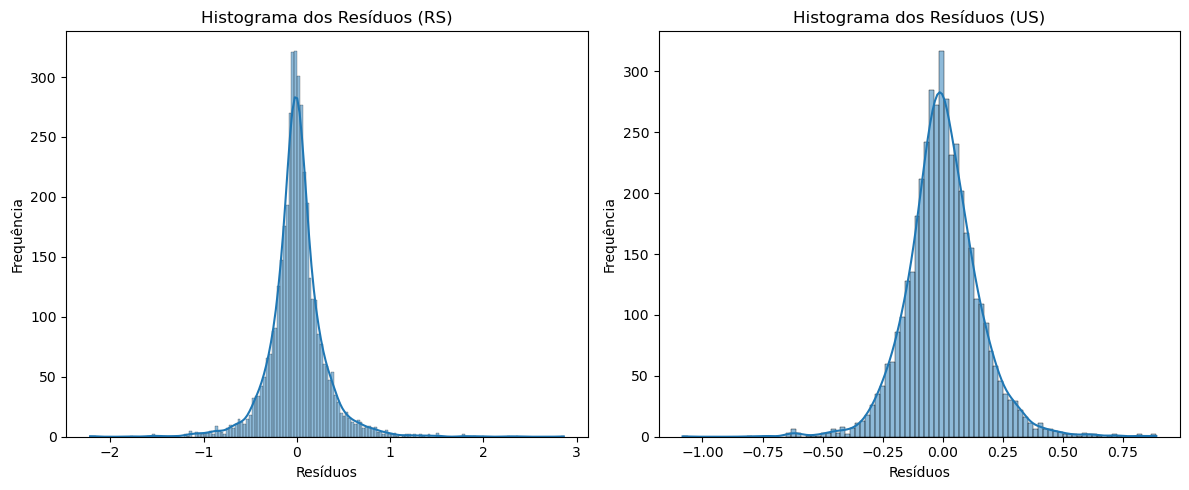

C:\Users\li_de\AppData\Local\Temp\ipykernel_2872\1140384571.py:51: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


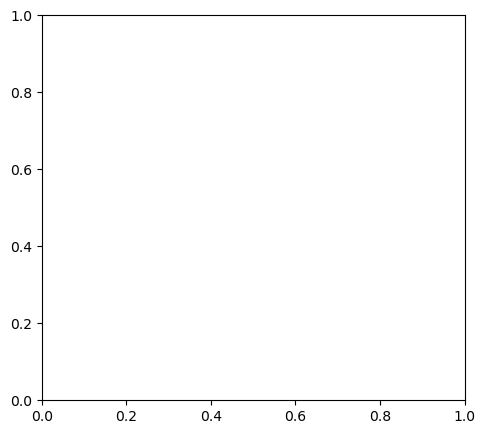

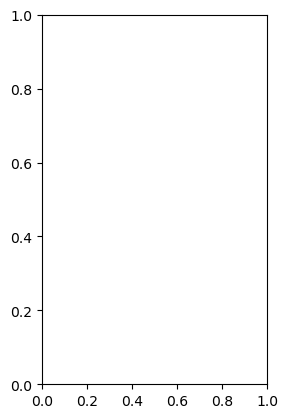

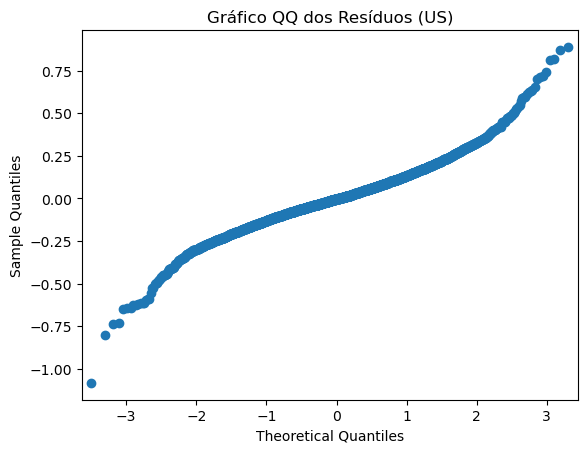

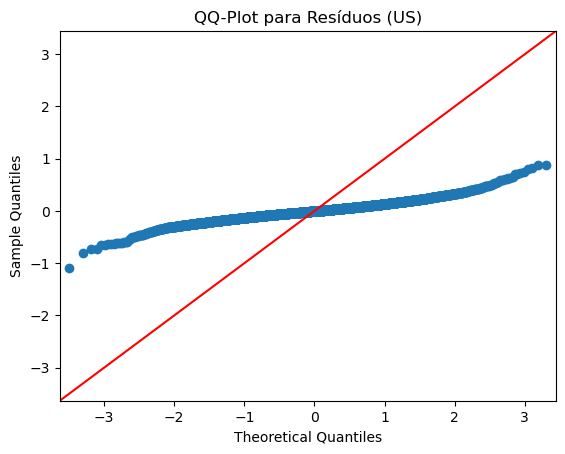

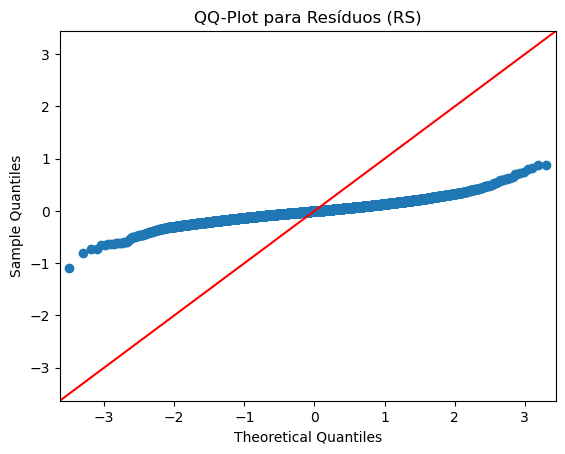

<Figure size 640x480 with 0 Axes>

In [72]:
#Visualização de Histograma e QQ-Plot

import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

# Ajuste o modelo ARIMA para a série "RS" (substitua os valores de p, d e q conforme necessário)
p_rs = 1
d_rs = 0
q_rs = 1
arima_order_rs = (p_rs, d_rs, q_rs)
model_rs = sm.tsa.ARIMA(train_data['RS'], order=arima_order_rs)
results_rs = model_rs.fit()

# Ajuste o modelo ARIMA para a série "US" (substitua os valores de p, d e q conforme necessário)
p_us = 1
d_us = 0
q_us = 1
arima_order_us = (p_us, d_us, q_us)
model_us = sm.tsa.ARIMA(train_data['US'], order=arima_order_us)
results_us = model_us.fit()

# Obtenha os resíduos dos modelos
residuals_rs = results_rs.resid
residuals_us = results_us.resid

# Crie um histograma dos resíduos para a série "RS"
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(residuals_rs, kde=True)
plt.title("Histograma dos Resíduos (RS)")
plt.xlabel("Resíduos")
plt.ylabel("Frequência")

# Crie um histograma dos resíduos para a série "US"
plt.subplot(1, 2, 2)
sns.histplot(residuals_us, kde=True)
plt.title("Histograma dos Resíduos (US)")
plt.xlabel("Resíduos")
plt.ylabel("Frequência")

plt.tight_layout()
plt.show()

# Crie gráficos QQ dos resíduos para ambas as séries
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sm.qqplot(residuals_rs, line='s')
plt.title("Gráfico QQ dos Resíduos (RS)")

plt.subplot(1, 2, 2)
sm.qqplot(residuals_us, line='s')
plt.title("Gráfico QQ dos Resíduos (US)")

sm.qqplot(residuals_us, line='45')
plt.title("QQ-Plot para Resíduos (US)")
plt.show()

sm.qqplot(residuals_us, line='45')
plt.title("QQ-Plot para Resíduos (RS)")
plt.show()

plt.tight_layout()
plt.show()


In [ ]:
#pelo histograma podemos achar que os resíduos parecem ter uma distribução normal. 
Porém ao observar o gráfico de distribuiçõ dos resíduos, os mesmos estão distantes da linha diagonal, 
que é usada como referência para verificar se os  pontos estão próximos dela, o que indicaria uma distribuição normal. 
Observamos que os pontos estão distantes desta linha 

In [70]:

from scipy.stats import kstest

# Realize o Teste de Kolmogorov-Smirnov nas séries "RS" e "US"
ks_statistic_rs, ks_p_value_rs = kstest(residuals_rs, 'norm')
ks_statistic_us, ks_p_value_us = kstest(residuals_us, 'norm')

# Imprima os resultados do Teste de Kolmogorov-Smirnov
print("Resultado do Teste de Kolmogorov-Smirnov para RS:")
print("Estatística de teste:", ks_statistic_rs)
print("Valor p:", ks_p_value_rs)

print("\nResultado do Teste de Kolmogorov-Smirnov para US:")
print("Estatística de teste:", ks_statistic_us)
print("Valor p:", ks_p_value_us)


Resultado do Teste de Kolmogorov-Smirnov para RS:
Estatística de teste: nan
Valor p: nan

Resultado do Teste de Kolmogorov-Smirnov para US:
Estatística de teste: nan
Valor p: nan


In [ ]:
#Os resultados obtidos a partir dos gráficos QQ-Plot e do Teste de Kolmogorov-Smirnov sugerem que os resíduos do modelo ARIMA 
podem não seguir uma distribuição normal. Quando os pontos no QQ-Plot estão afastados da linha diagonal de 45 graus, 
como você observou, isso indica desvio da normalidade. 
Além disso, os valores "nan" nos resultados do Teste de Kolmogorov-Smirnov indicam que o teste não pôde ser calculado 
devido à falta de normalidade nos resíduos.

Isso pode sugerir que o modelo ARIMA não é a melhor escolha para modelar essas séries temporais 
ou que talvez seja necessário realizar mais ajustes no modelo. Resíduos não normalmente distribuídos podem indicar 
que há estrutura não capturada nos dados, ou que o modelo precisa de revisões em sua especificação.
